In [237]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [238]:
def plot_failure_rate_by_column(df, column, project_type):
    """
    Plots the failure rate by a given column in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column to group by and plot the failure rate.
    status_filter (str): The project status to filter on. Used for the chart title.
    threshold (float): An optional threshold to filter the failure rate. Defaults to None.
    
    Returns:
    None
    """
    # Calculate the failure rate and the ratio of num_failed/total
    grouped = df.groupby(column).agg(
        num_failed=('failure', 'sum'),
        total=('failure', 'size')
    )
    grouped['failure_rate'] = grouped['num_failed'] / grouped['total']
    
    # Filter out entries with 0 failure rate
    grouped = grouped[grouped['failure_rate'] > 0]
    grouped = grouped.head(20)
    
    # Sort the failure rate
    grouped = grouped.sort_values(by='failure_rate', ascending=False)
    
    # Plot the failure rate
    plt.figure(figsize=(12, 8))
    bars = plt.bar(grouped.index, grouped['failure_rate'], color='skyblue')
    plt.title(f'Failure Rate of {project_type} projects by {column}')
    # plt.title(f'Failure Rate by {column.replace("_", " ").title()} (where project status == "{status_filter}")')
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Failure Rate')
    plt.xticks(rotation=45, ha='right')
    
    # Add text annotations on top of the bars
    for bar, num_failed, total in zip(bars, grouped['num_failed'], grouped['total']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{num_failed}/{total}', 
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
def plot_based_on_failure(df, col, bins=10):
    """
    Plots the distribution of the difference in days based on failure condition.

    Parameters:
    - df: pandas DataFrame containing the data.
    - bins: number of bins for the histogram (default is 10).
    """
    # Separate the data based on the condition of failure
    df_failed = df[df['failure']][col]
    df_succeeded = df[~df['failure']][col]

    # Plot the distributions
    plt.figure(figsize=(10, 6))
    plt.hist(df_failed, bins=bins, alpha=0.5, label=f'failure = True')
    plt.hist(df_succeeded, bins=bins, alpha=0.5, label=f'failure = False')

    # Adding titles and labels
    plt.title('Distribution of start_and_planned_end_diff based on failure')
    plt.xlabel('col')
    plt.ylabel('Frequency')
    plt.legend()

    # Show plot
    plt.show()

def calculate_failure_rate(df, column='failure'):
    # Ensure the column exists in the DataFrame
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")
    
    # Calculate the count of False values
    false_count = df[column].value_counts().get(True, 0)
    
    # Calculate the total count of non-missing values in the column
    total_count = df[column].notna().sum()
    
    # Avoid division by zero
    if total_count == 0:
        return 0

    # Calculate the failure rate (percentage of False values)
    failure_rate = (false_count / total_count) * 100

    return failure_rate


In [239]:
df = pd.read_csv("https://datasocibmproject.s3.ap-southeast-2.amazonaws.com/structured_data/capital_project_schedules_and_budgets_1.csv")
df = df.drop(df.columns[0], axis=1)

In [240]:
status_filter='In-Progress'
df = df[df['project_status_name'] == status_filter]
# Drop actual end date because all are null values
df = df.drop(columns=['project_status_name', 'project_phase_actual_end_date'])

fail_rate = calculate_failure_rate(df)
print(f"Failure rate: {fail_rate:.2f}")

df.shape

Failure rate: 27.29


(2158, 13)

In [241]:
pd.set_option('display.max_rows', None)

In [242]:
borough_districts = {
    'manhattan': [i for i in range(1, 7)],
    'bronx': [i for i in range(7, 13)], 
    'brooklyn': [i for i in range(13, 24)] + [32],
    'queens': [i for i in range(24, 31)],
    'staten-island': [31]
}

for borough, districts in borough_districts.items():
    df[borough] = 0
    df.loc[df['project_geographic_district'].isin(districts), borough] = 1

# Function to get the column name with value 1
def map_borough(row):
    for col in borough_districts.keys():
        if row[col] == 1:
            return col
    return None

# Apply the function to create the new column
df['borough'] = df.apply(map_borough, axis=1)
df = df.drop(columns=['project_geographic_district'])

In [243]:
# Converting numerical columns to appropriate types
df['project_budget_amount'] = pd.to_numeric(df['project_budget_amount'], errors='coerce')
df['final_estimate_of_actual_costs_through_end_of_phase_amount'] = pd.to_numeric(df['final_estimate_of_actual_costs_through_end_of_phase_amount'], errors='coerce')
df['total_phase_actual_spending_amount'] = pd.to_numeric(df['total_phase_actual_spending_amount'], errors='coerce')

# Difference between budget and actual spending relative to spending
df['over_budget_percentage'] = ((df['project_budget_amount'] - df['total_phase_actual_spending_amount']) / df['project_budget_amount']).round(2) * 100

In [244]:
# Converting date columns to datetime format
df['project_phase_actual_start_date'] = pd.to_datetime(df['project_phase_actual_start_date'], errors='coerce')
df['project_phase_planned_end_date'] = pd.to_datetime(df['project_phase_planned_end_date'], errors='coerce')

df['start_and_planned_end_diff'] = (df['project_phase_planned_end_date'] - df['project_phase_actual_start_date']).dt.days

In [245]:
mean_difference = df['start_and_planned_end_diff'].mean()
median_difference = df['start_and_planned_end_diff'].median()
std_difference = df['start_and_planned_end_diff'].std()

# Print the results
print(f"Mean: {mean_difference}")
print(f"Median: {median_difference}")
print(f"Standard Deviation: {std_difference}")

Mean: 384.64745508982037
Median: 299.0
Standard Deviation: 300.114803191449


In [246]:
project_type = 'RESOA'
df_subset = df[df['project_type'].str.contains(project_type)]

fail_rate = calculate_failure_rate(df_subset)
print(f"Failure rate: {fail_rate:.2f}")

print(df_subset['project_description'].value_counts())

Failure rate: 36.14
project_description
FY17 RESO A TECHNOLOGY                                55
FY17 RESO A AUDITORIUM  UPGRADE                       27
FY16 RESO A AUDITORIUM UPGRADE                        22
FY18 RESO A TOILETS-STUDENTS                          15
FY17 RESO A PLAYGROUND REDEVELOPMENT                  13
FY16 RESO A IP SURVEILLANCE CAMERA INSTALLATION       10
FY16 RESO A LIBRARY UPGRADE                           10
FY17 RESO A GYMNASIUM UPGRADE                          9
FY17 RESO A LIBRARY UPGRADES                           9
FY15 RESO A AUDITORIUM UPGRADE                         8
FY16 RESO A GYMNASIUM UPGRADE                          8
FY17 RESO A IP SURVEILLANCE CAMERA INSTALLATION        8
FY17 RESO A TOILETS-STUDENTS                           7
FY17 RESO A ELECTRICAL SYSTEMS                         7
FY18 RESO A SUPPLEMENTAL COOLING                       6
FY17 RESO A ROOM CONVERSIONS/PARTITIONING              6
FY17 RESO A SCIENCE LAB UPGRADES                

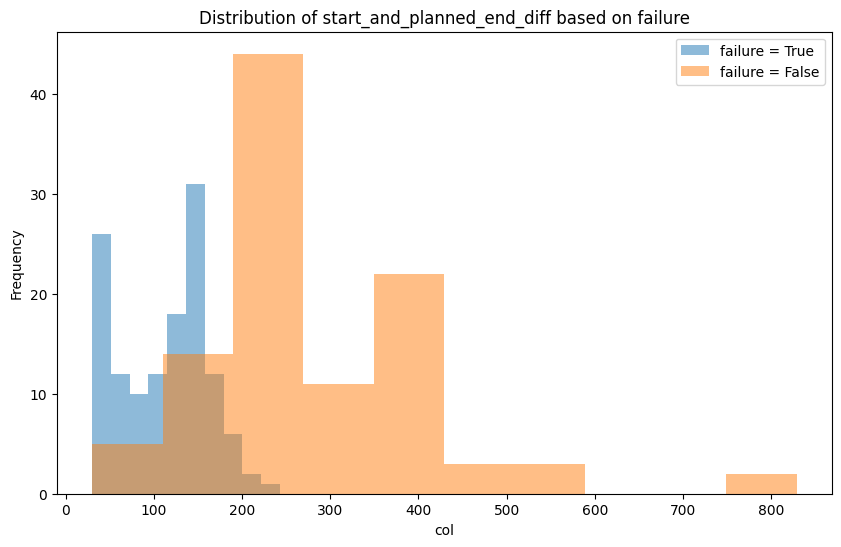

156.0

In [247]:
# Example usage with your DataFrame
plot_based_on_failure(
    df=df_subset, 
    col='start_and_planned_end_diff', 
    bins=10
)

df_subset['start_and_planned_end_diff'].median()

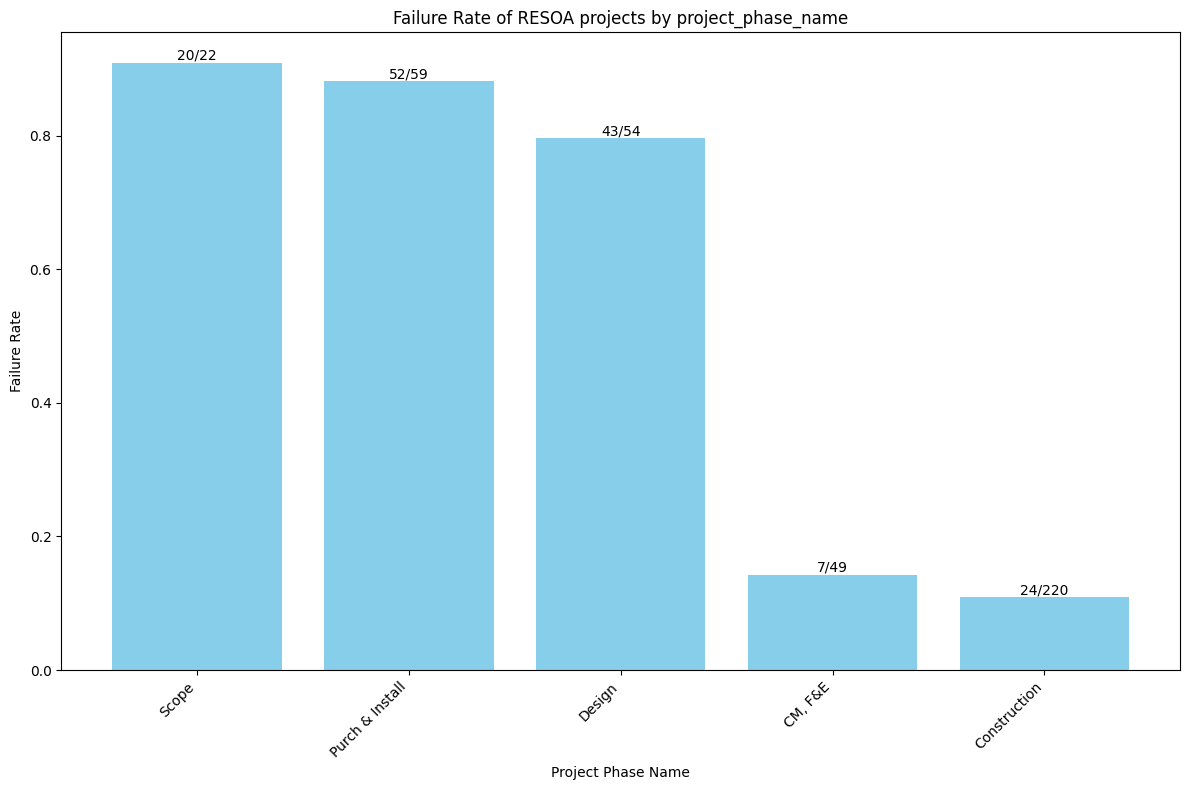

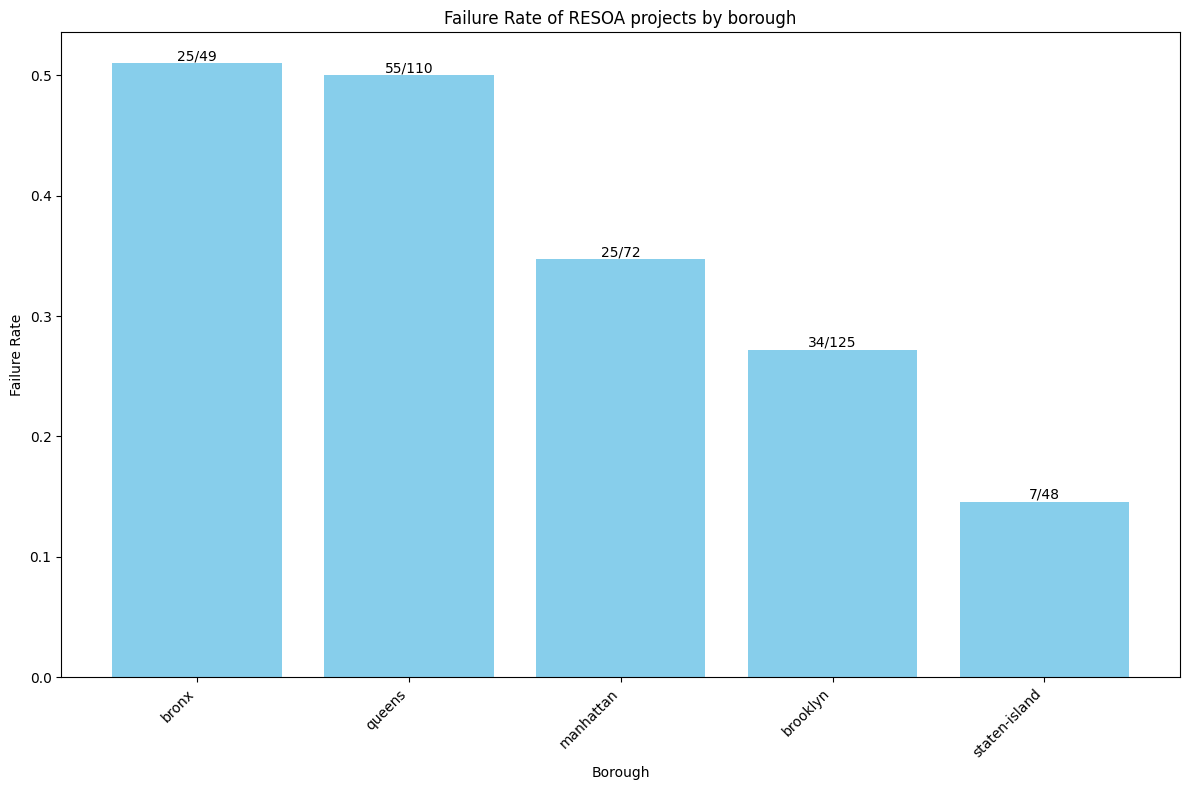

In [248]:
agg_by = 'project_phase_name'
plot_failure_rate_by_column(df_subset, agg_by, project_type)

agg_by = 'borough'
plot_failure_rate_by_column(df_subset, agg_by, project_type)

Budget and cost

In [249]:
# Had a brief look at the budgets here for DIIT projects

# df_subset[df_subset['project_type'].str.contains('RESOA')]
# df_subset[df_subset['project_type'].str.contains('Conne')]

In [250]:
# Separate the data based on the condition of failure
df_failed = df_subset[df_subset['failure']]
df_succeeded = df_subset[~df_subset['failure']]

print(df_failed.shape[0])
print(df_succeeded.shape[0])

146
258


In [251]:
df_subset.loc[:, 'over_budget_percentage'] = df_subset['over_budget_percentage'].replace([np.inf, -np.inf], np.nan)
df_subset.dropna(subset=['over_budget_percentage'], inplace=True)

/var/folders/l7/rfx8sr1s2h32jhyxdrb33h_40000gn/T/ipykernel_45965/2556343740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.dropna(subset=['over_budget_percentage'], inplace=True)


In [252]:
# Separate the data based on the condition of failure
df_failed = df_subset[df_subset['failure']]
df_succeeded = df_subset[~df_subset['failure']]

print(df_failed.shape[0])
print(df_succeeded.shape[0])

113
252


In [253]:
mean_difference = df_subset[df_subset['failure']]['over_budget_percentage'].mean()
median_difference = df_subset[df_subset['failure']]['over_budget_percentage'].median()
std_difference = df_subset[df_subset['failure']]['over_budget_percentage'].std()

# Print the results
print(f"Mean: {mean_difference:.2f}")
print(f"Median: {median_difference:.2f}")
print(f"Standard Deviation: {std_difference:.2f}")

Mean: 23.43
Median: 9.00
Standard Deviation: 101.87


In [254]:
mean_difference = df_subset[~df_subset['failure']]['over_budget_percentage'].mean()
median_difference = df_subset[~df_subset['failure']]['over_budget_percentage'].median()
std_difference = df_subset[~df_subset['failure']]['over_budget_percentage'].std()

# Print the results
print(f"Mean: {mean_difference:.2f}")
print(f"Median: {median_difference:.2f}")
print(f"Standard Deviation: {std_difference:.2f}")

Mean: 40.97
Median: 43.50
Standard Deviation: 43.86


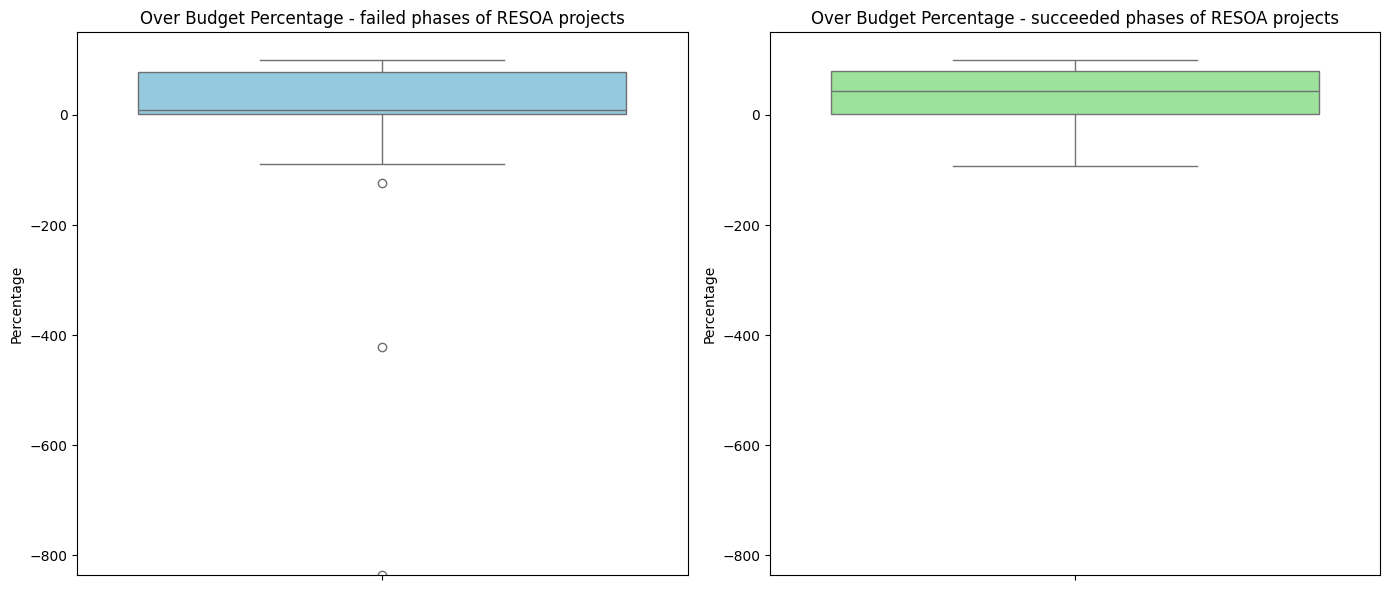

In [255]:
# Determine the common y-axis limits
y_min = min(df_failed['over_budget_percentage'].min(), df_succeeded['over_budget_percentage'].min())
y_max = max(df_failed['over_budget_percentage'].max(), df_succeeded['over_budget_percentage'].max()) + 50


# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for 'over_budget_percentage'
sns.boxplot(y=df_failed['over_budget_percentage'], color='skyblue', ax=axes[0])
axes[0].set_title(f'Over Budget Percentage - failed phases of {project_type} projects')
axes[0].set_ylabel('Percentage')
axes[0].set_ylim(y_min, y_max)

# Box plot for 'another_metric'
sns.boxplot(y=df_succeeded['over_budget_percentage'], color='lightgreen', ax=axes[1])
axes[1].set_title(f'Over Budget Percentage - succeeded phases of {project_type} projects')
axes[1].set_ylabel('Percentage')
axes[1].set_ylim(y_min, y_max)

# Display the plots
plt.tight_layout()
plt.show()


In [256]:
# # Calculate the median values
# median_values = df.groupby('project_type')['budget_spending_diff'].median().reset_index()

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(median_values['project_type'], median_values['budget_spending_diff'], marker='o', linestyle='-')
# plt.xlabel('project_type')
# plt.ylabel(f'Median of budget_spending_diff')
# plt.title(f'Median of budget_spending_diff by project_type')
# plt.grid(True)
# plt.show()